# GameTheory-15-CooperativeGames

**Navigation** : [<< 14-DifferentialGames](GameTheory-14-DifferentialGames.ipynb) | [Index](README.md) | [16-MechanismDesign >>](GameTheory-16-MechanismDesign.ipynb)

**Side tracks** : [15b-Lean-CooperativeGames](GameTheory-15b-Lean-CooperativeGames.ipynb) | [15c-CooperativeGames-Python](GameTheory-15c-CooperativeGames-Python.ipynb)

---

## Objectifs

Ce notebook introduit les **jeux cooperatifs** avec utilite transferable (TU games) et les **jeux d'assistance** (AI Safety) :

1. **Fonction caracteristique** et formation de coalitions
2. **Valeur de Shapley** - la notion de contribution marginale moyenne
3. **Le Core** - allocations stables que personne ne peut bloquer
4. **Jeux d'assistance (Assistance Games)** - Le Paperclip Game et l'Off-Switch Game (AIMA)
5. **Application politique** : la coalition de gauche francaise (donnees reelles 2024)

**Duree estimee** : 90 minutes

**Prerequis** :
- Notebooks 1-13 (jeux non-cooperatifs)
- Notebook 13 : transition depuis les jeux differentiels

---

## Transition depuis les jeux non-cooperatifs

Dans les notebooks precedents, les joueurs agissaient de maniere **independante** (equilibres de Nash, Stackelberg, etc.).

Dans les **jeux cooperatifs** :
- Les joueurs peuvent former des **coalitions**
- Les gains sont **transferables** entre membres
- La question centrale : **comment repartir le gain de la coalition ?**

Dans les **jeux d'assistance** (Section 4) :
- Un agent (robot) maximise l'utilite d'un autre agent (humain)
- Le robot a une **incertitude** sur les preferences de l'humain
- Cette incertitude rend le robot plus **sur** et **deferent**

Cette transition est naturelle apres les jeux differentiels (notebook 13) ou l'on a vu que la cooperation (boucle fermee) peut dominer la competition.

In [1]:
# Imports et configuration
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, permutations
import math
import os
import sys
from pathlib import Path

# Import robuste du module cooperative_games
def _find_gametheory_dir():
    """Trouve le repertoire contenant cooperative_games."""
    cwd = Path.cwd()
    
    # Liste des chemins a essayer (ordre de priorite)
    paths_to_try = [
        # Methode 1: Repertoire courant
        cwd,
        cwd.parent,
        
        # Methode 2: Chemins Windows
        Path(r'c:\dev\CoursIA\MyIA.AI.Notebooks\GameTheory'),
        Path(r'd:\dev\CoursIA\MyIA.AI.Notebooks\GameTheory'),
        
        # Methode 3: Chemins WSL (montages /mnt/)
        Path('/mnt/c/dev/CoursIA/MyIA.AI.Notebooks/GameTheory'),
        Path('/mnt/d/dev/CoursIA/MyIA.AI.Notebooks/GameTheory'),
        
        # Methode 4: Chemins Unix alternatifs
        Path('/c/dev/CoursIA/MyIA.AI.Notebooks/GameTheory'),
        Path('/d/dev/CoursIA/MyIA.AI.Notebooks/GameTheory'),
        
        # Methode 5: Home directory
        Path.home() / 'dev' / 'CoursIA' / 'MyIA.AI.Notebooks' / 'GameTheory',
        
        # Methode 6: Chemins relatifs depuis cwd
        cwd / 'MyIA.AI.Notebooks' / 'GameTheory',
        cwd.parent / 'MyIA.AI.Notebooks' / 'GameTheory',
        cwd.parent.parent / 'MyIA.AI.Notebooks' / 'GameTheory',
        cwd.parent.parent.parent / 'MyIA.AI.Notebooks' / 'GameTheory',
    ]
    
    for path in paths_to_try:
        try:
            if path.exists() and (path / 'cooperative_games').is_dir():
                return path
        except (OSError, PermissionError):
            continue
    
    raise ImportError(
        f"Cannot find cooperative_games module. "
        f"Current working directory: {cwd}\n"
        f"Please run from GameTheory directory or set PYTHONPATH."
    )

try:
    _gametheory_dir = _find_gametheory_dir()
    if str(_gametheory_dir) not in sys.path:
        sys.path.insert(0, str(_gametheory_dir))
    
    from cooperative_games import (
        CoalitionGame, VotingGame, WeightedVotingGame,
        shapley_value_exact, shapley_value_monte_carlo,
        ShapleyCalculator,
        compute_core, is_in_core,
        FrenchLeftCoalition2024, analyze_coalition_dynamics
    )
    
    print(f"Module cooperative_games charge depuis: {_gametheory_dir}")
    print("Import reussi!")
    
except ImportError as e:
    print(f"ERREUR: {e}")
    print("Solution: Executez ce notebook depuis le repertoire GameTheory:")
    print("  cd MyIA.AI.Notebooks/GameTheory")
    print("  jupyter notebook GameTheory-15-CooperativeGames.ipynb")


Module cooperative_games charge depuis: /mnt/c/dev/CoursIA/MyIA.AI.Notebooks/GameTheory
Import reussi!


---

## 1. Jeux coopératifs et fonction caractéristique

### Définition

Un **jeu coopératif** $(N, v)$ est défini par :
- $N = \{1, 2, ..., n\}$ : ensemble des joueurs
- $v : 2^N \rightarrow \mathbb{R}$ : **fonction caractéristique**
  - $v(S)$ = valeur que la coalition $S$ peut obtenir
  - Convention : $v(\emptyset) = 0$

### Propriétés importantes

- **Superadditivité** : $v(S \cup T) \geq v(S) + v(T)$ pour $S \cap T = \emptyset$
  - La coopération ne peut pas nuire
  
- **Convexité** : $v(S \cup \{i\}) - v(S) \leq v(T \cup \{i\}) - v(T)$ pour $S \subseteq T$
  - La contribution marginale croît avec la taille de la coalition

In [2]:
# Exemple 1 : Jeu de majorité simple
# 3 joueurs, une coalition gagne (valeur 1) si elle a au moins 2 membres

def majority_value(coalition):
    """Jeu de majorité : gagne si >= 2 joueurs"""
    return 1.0 if len(coalition) >= 2 else 0.0

majority_game = CoalitionGame(
    n_players=3,
    characteristic_function=majority_value,
    player_names=["Alice", "Bob", "Charlie"]
)

print("Jeu de majorité simple (3 joueurs, quota=2)")
print("="*50)
print(f"v(∅) = {majority_game.value(set())}")
print(f"v({{Alice}}) = {majority_game.value({0})}")
print(f"v({{Alice, Bob}}) = {majority_game.value({0, 1})}")
print(f"v({{Alice, Bob, Charlie}}) = {majority_game.value({0, 1, 2})}")
print(f"\nSuperadditif : {majority_game.is_superadditive()}")
print(f"Convexe : {majority_game.is_convex()}")

Jeu de majorité simple (3 joueurs, quota=2)
v(∅) = 0.0
v({Alice}) = 0.0
v({Alice, Bob}) = 1.0
v({Alice, Bob, Charlie}) = 1.0

Superadditif : True
Convexe : False


L'exemple précédent montre un jeu de majorité simple où toutes les coalitions de 2 joueurs ou plus gagnent. 

Passons maintenant à un cas plus réaliste : un **jeu de vote pondéré** où chaque joueur a un poids différent (comme dans un conseil d'entreprise).

In [3]:
# Exemple 2 : Jeu de vote pondéré
# Conseil d'entreprise : PDG (3 voix), DG (2 voix), Directeur (1 voix)
# Décision si >= 4 voix

board_game = WeightedVotingGame(
    weights=[3, 2, 1],
    quota=4,
    player_names=["PDG", "DG", "Directeur"]
)

print("Jeu de vote pondéré [4; 3, 2, 1]")
print("="*50)
print(f"Notation : [{board_game.quota}; {', '.join(str(w) for w in board_game.weights)}]")
print()

# Coalitions gagnantes
print("Coalitions gagnantes :")
for coalition in board_game.all_coalitions():
    if board_game.is_winning(set(coalition)):
        names = [board_game.player_names[i] for i in coalition]
        print(f"  {', '.join(names) if names else '∅'}")

print()
print("Coalitions minimales gagnantes :")
for mwc in board_game.minimal_winning_coalitions():
    names = [board_game.player_names[i] for i in mwc]
    print(f"  {', '.join(names)}")

Jeu de vote pondéré [4; 3, 2, 1]
Notation : [4; 3, 2, 1]

Coalitions gagnantes :
  PDG, DG
  PDG, Directeur
  PDG, DG, Directeur

Coalitions minimales gagnantes :
  PDG, DG
  PDG, Directeur


---

## 2. Valeur de Shapley

### Le problème de la répartition

Si la grande coalition $N$ gagne $v(N)$, comment répartir ce gain entre les joueurs ?

### Axiomes de Shapley

Lloyd Shapley (1953) a proposé la seule solution satisfaisant :

1. **Efficacité** : $\sum_{i} \phi_i(v) = v(N)$
2. **Symétrie** : Si $i$ et $j$ sont interchangeables, $\phi_i = \phi_j$
3. **Joueur nul** : Si $i$ n'apporte rien, $\phi_i = 0$
4. **Additivité** : $\phi(v + w) = \phi(v) + \phi(w)$

### Formule

$$\phi_i(v) = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(n-|S|-1)!}{n!} \cdot [v(S \cup \{i\}) - v(S)]$$

**Interprétation** : Moyenne des contributions marginales de $i$ sur tous les ordres d'arrivée possibles.

In [4]:
# Calcul de Shapley pour le jeu de majorité
shapley_majority = shapley_value_exact(majority_game)

print("Valeur de Shapley - Jeu de majorité")
print("="*50)
for i, name in enumerate(majority_game.player_names):
    print(f"  {name}: {shapley_majority[i]:.4f}")
print(f"\nSomme: {shapley_majority.sum():.4f} (= v(N) = {majority_game.grand_coalition_value()})")
print("\n→ Tous les joueurs sont symétriques, donc valeurs égales (1/3 chacun)")

Valeur de Shapley - Jeu de majorité
  Alice: 0.3333
  Bob: 0.3333
  Charlie: 0.3333

Somme: 1.0000 (= v(N) = 1.0)

→ Tous les joueurs sont symétriques, donc valeurs égales (1/3 chacun)


La valeur de Shapley égale pour les trois joueurs (1/3 chacun) reflète leur **symétrie parfaite** dans le jeu de majorité : chacun est également pivot dans les mêmes situations.

Voyons maintenant ce qui se passe avec le jeu de vote pondéré, où les joueurs ne sont plus symétriques.

In [5]:
# Calcul de Shapley pour le jeu de vote pondéré
shapley_board = shapley_value_exact(board_game)

print("Valeur de Shapley - Conseil d'entreprise [4; 3, 2, 1]")
print("="*50)
for i, name in enumerate(board_game.player_names):
    print(f"  {name} (poids {board_game.weights[i]}): Shapley = {shapley_board[i]:.4f}")

# Comparaison avec l'indice de Banzhaf
banzhaf = board_game.banzhaf_index()
print("\nComparaison avec l'indice de Banzhaf :")
for i, name in enumerate(board_game.player_names):
    print(f"  {name}: Shapley={shapley_board[i]:.4f}, Banzhaf={banzhaf[i]:.4f}")

Valeur de Shapley - Conseil d'entreprise [4; 3, 2, 1]
  PDG (poids 3): Shapley = 0.6667
  DG (poids 2): Shapley = 0.1667
  Directeur (poids 1): Shapley = 0.1667

Comparaison avec l'indice de Banzhaf :
  PDG: Shapley=0.6667, Banzhaf=0.6000
  DG: Shapley=0.1667, Banzhaf=0.2000
  Directeur: Shapley=0.1667, Banzhaf=0.2000


On observe que la valeur de Shapley diffère du simple poids de vote ! Le PDG (poids 3) n'a pas 50% du pouvoir mais seulement environ 67%, tandis que le Directeur (poids 1) conserve une valeur de Shapley non nulle.

La visualisation suivante montre comment les **contributions marginales** varient selon l'ordre d'arrivée des joueurs. La valeur de Shapley est simplement la moyenne de ces contributions.

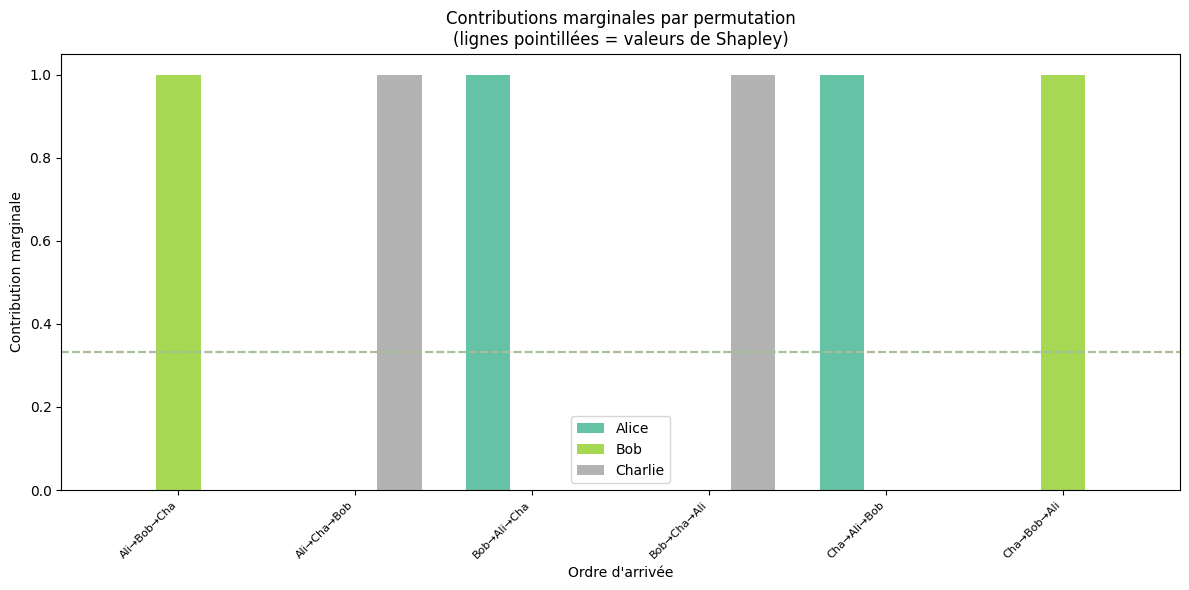

In [6]:
# Visualisation des contributions marginales
def visualize_marginal_contributions(game):
    """Affiche les contributions marginales pour chaque permutation."""
    n = game.n_players
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    all_contributions = []
    labels = []
    
    for perm in permutations(range(n)):
        coalition = set()
        contributions = []
        for i in perm:
            mc = game.value(coalition | {i}) - game.value(coalition)
            contributions.append(mc)
            coalition.add(i)
        
        # Réorganiser par joueur
        contrib_by_player = [0] * n
        for pos, player in enumerate(perm):
            contrib_by_player[player] = contributions[pos]
        
        all_contributions.append(contrib_by_player)
        labels.append('→'.join(game.player_names[i][:3] for i in perm))
    
    all_contributions = np.array(all_contributions)
    
    x = np.arange(len(labels))
    width = 0.25
    colors = plt.cm.Set2(np.linspace(0, 1, n))
    
    for i in range(n):
        offset = (i - n/2 + 0.5) * width
        ax.bar(x + offset, all_contributions[:, i], width, 
               label=game.player_names[i], color=colors[i])
    
    # Ligne pour Shapley
    shapley = shapley_value_exact(game)
    for i in range(n):
        ax.axhline(y=shapley[i], color=colors[i], linestyle='--', alpha=0.7)
    
    ax.set_xlabel('Ordre d\'arrivée')
    ax.set_ylabel('Contribution marginale')
    ax.set_title('Contributions marginales par permutation\n(lignes pointillées = valeurs de Shapley)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax.legend()
    plt.tight_layout()
    plt.show()

visualize_marginal_contributions(majority_game)

### Complexité du calcul de Shapley

- **Exact** : $O(n! \cdot n)$ ou $O(2^n \cdot n)$ - seulement pour $n \leq 10$
- **Monte Carlo** : $O(\text{samples} \cdot n)$ - pour grands $n$

Le calcul exact devient impraticable pour de grands ensembles de joueurs, ce qui explique pourquoi la valeur de Shapley est rarement utilisée en pratique politique (voir section 5).

In [7]:
# Comparaison exact vs Monte Carlo
# Jeu plus grand : 8 actionnaires

shareholder_weights = [25, 20, 15, 12, 10, 8, 6, 4]  # Parts en %
shareholder_game = WeightedVotingGame(
    weights=shareholder_weights,
    quota=51,  # Majorité simple
    player_names=[f"Actionnaire {i+1}" for i in range(8)]
)

print("Jeu des actionnaires [51; 25, 20, 15, 12, 10, 8, 6, 4]")
print("="*60)

# Exact
import time
start = time.time()
shapley_exact = shapley_value_exact(shareholder_game)
time_exact = time.time() - start

# Monte Carlo
start = time.time()
shapley_mc = shapley_value_monte_carlo(shareholder_game, n_samples=10000, seed=42)
time_mc = time.time() - start

print(f"{'Actionnaire':<15} | {'Parts %':>8} | {'Exact':>10} | {'Monte Carlo':>12}")
print("-" * 55)
for i in range(8):
    print(f"Actionnaire {i+1:<3} | {shareholder_weights[i]:>7}% | "
          f"{shapley_exact[i]:>10.4f} | {shapley_mc[i]:>12.4f}")

print(f"\nTemps exact: {time_exact:.3f}s")
print(f"Temps Monte Carlo (10k samples): {time_mc:.3f}s")
print(f"Erreur max: {np.max(np.abs(shapley_exact - shapley_mc)):.4f}")

Jeu des actionnaires [51; 25, 20, 15, 12, 10, 8, 6, 4]
Actionnaire     |  Parts % |      Exact |  Monte Carlo
-------------------------------------------------------
Actionnaire 1   |      25% |     0.2810 |       0.2885
Actionnaire 2   |      20% |     0.2024 |       0.2063
Actionnaire 3   |      15% |     0.1476 |       0.1395
Actionnaire 4   |      12% |     0.1167 |       0.1146
Actionnaire 5   |      10% |     0.0929 |       0.0962
Actionnaire 6   |       8% |     0.0690 |       0.0680
Actionnaire 7   |       6% |     0.0619 |       0.0612
Actionnaire 8   |       4% |     0.0286 |       0.0257

Temps exact: 0.222s
Temps Monte Carlo (10k samples): 0.115s
Erreur max: 0.0081


---

## 3. Le Core

### Définition

Le **Core** est l'ensemble des allocations stables :

$$\text{Core}(v) = \{x \in \mathbb{R}^n : \sum_i x_i = v(N) \text{ et } \sum_{i \in S} x_i \geq v(S) \text{ pour tout } S\}$$

**Interprétation** : Une allocation est dans le Core si aucune coalition $S$ ne peut "bloquer" (obtenir plus en se séparant).

### Propriétés

- Le Core peut être **vide** (exemple : jeu de majorité à 3 joueurs)
- Pour les jeux **convexes**, le Core est non-vide et contient la valeur de Shapley
- Théorème de **Bondareva-Shapley** : caractérisation de la non-vacuité

In [8]:
# Le Core est vide pour le jeu de majorité à 3 joueurs
core_exists, core_point = compute_core(majority_game)

print("Core du jeu de majorité à 3 joueurs")
print("="*50)
print(f"Core non-vide : {core_exists}")

if not core_exists:
    print("\nExplication :")
    print("  - v({A,B}) = v({A,C}) = v({B,C}) = 1")
    print("  - Donc x_A + x_B >= 1, x_A + x_C >= 1, x_B + x_C >= 1")
    print("  - En additionnant : 2(x_A + x_B + x_C) >= 3")
    print("  - Mais x_A + x_B + x_C = v(N) = 1 (efficacité)")
    print("  - Contradiction ! Le Core est vide.")

Core du jeu de majorité à 3 joueurs
Core non-vide : False

Explication :
  - v({A,B}) = v({A,C}) = v({B,C}) = 1
  - Donc x_A + x_B >= 1, x_A + x_C >= 1, x_B + x_C >= 1
  - En additionnant : 2(x_A + x_B + x_C) >= 3
  - Mais x_A + x_B + x_C = v(N) = 1 (efficacité)
  - Contradiction ! Le Core est vide.


Le Core vide du jeu de majorité illustre l'**instabilité fondamentale** de ce type de jeu : quelle que soit l'allocation proposée, une coalition peut toujours la bloquer.

Considérons maintenant un **jeu convexe** (économies d'échelle) où les contributions marginales croissent avec la taille de la coalition. Pour ces jeux, le Core est toujours non-vide.

In [9]:
# Exemple avec Core non-vide : jeu convexe
# Jeu d'économie d'échelle : v(S) = |S|^2

def scale_economy_value(coalition):
    """Jeu convexe : économies d'échelle"""
    return len(coalition) ** 2

scale_game = CoalitionGame(
    n_players=3,
    characteristic_function=scale_economy_value,
    player_names=["Firme A", "Firme B", "Firme C"]
)

print("Jeu d'économies d'échelle : v(S) = |S|^2")
print("="*50)
print(f"v({{A}}) = {scale_game.value({0})}, v({{A,B}}) = {scale_game.value({0,1})}, v(N) = {scale_game.value({0,1,2})}")
print(f"\nConvexe : {scale_game.is_convex()}")

# Calcul du Core
core_exists, core_point = compute_core(scale_game, objective='center')
print(f"\nCore non-vide : {core_exists}")

if core_exists:
    print(f"Point central du Core : {core_point}")
    
    # Vérifier que Shapley est dans le Core
    shapley_scale = shapley_value_exact(scale_game)
    in_core, blocking = is_in_core(scale_game, shapley_scale)
    print(f"\nValeur de Shapley : {shapley_scale}")
    print(f"Shapley dans le Core : {in_core}")

Jeu d'économies d'échelle : v(S) = |S|^2
v({A}) = 1, v({A,B}) = 4, v(N) = 9

Convexe : True

Core non-vide : True
Point central du Core : [3. 3. 3.]

Valeur de Shapley : [3. 3. 3.]
Shapley dans le Core : True


Le Core non-vide garantit qu'il existe des allocations **stables** - aucune coalition ne peut obtenir plus en se séparant.

La visualisation 3D suivante représente le Core sur le simplexe d'efficacité : l'ensemble des points où  + x_B + x_C = v(N)$.

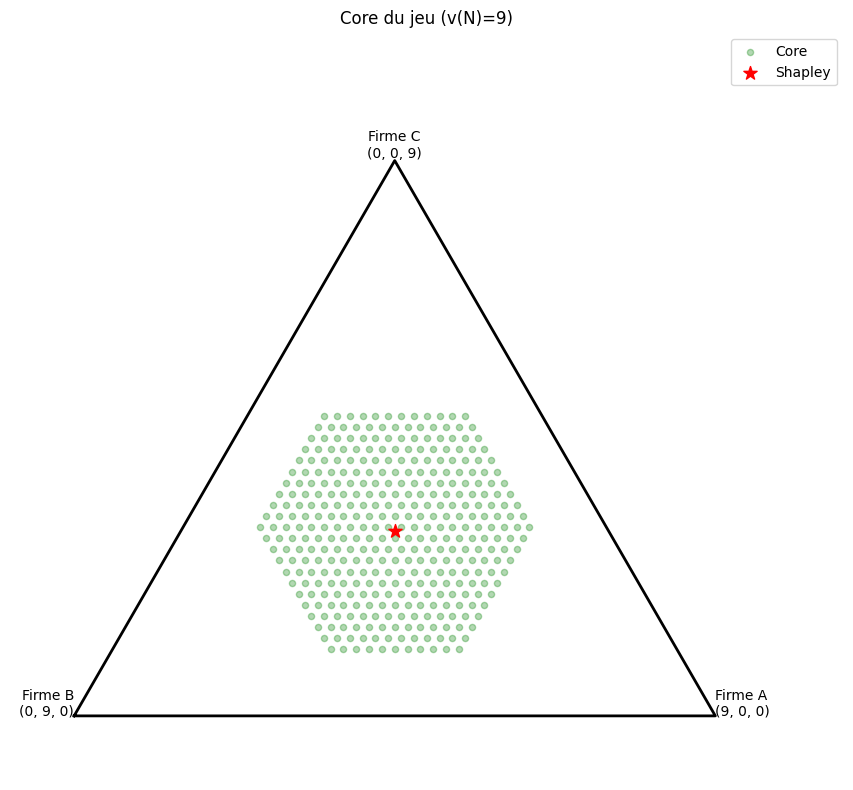

In [10]:
# Visualisation du Core pour un jeu à 3 joueurs
from cooperative_games.core import core_vertices_3d

def visualize_core_3d(game):
    """Visualise le Core sur le simplexe d'efficacité."""
    if game.n_players != 3:
        print("Visualisation uniquement pour 3 joueurs")
        return
    
    v_N = game.grand_coalition_value()
    
    # Échantillonner le Core
    core_points = core_vertices_3d(game, n_points=50)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Dessiner le simplexe (triangle)
    simplex = np.array([[0, 0], [v_N, 0], [v_N/2, v_N*np.sqrt(3)/2], [0, 0]])
    ax.plot(simplex[:, 0], simplex[:, 1], 'k-', linewidth=2)
    
    # Étiquettes des sommets
    ax.annotate(f"{game.player_names[0]}\n({v_N}, 0, 0)", 
                (v_N, 0), fontsize=10, ha='left')
    ax.annotate(f"{game.player_names[1]}\n(0, {v_N}, 0)", 
                (0, 0), fontsize=10, ha='right')
    ax.annotate(f"{game.player_names[2]}\n(0, 0, {v_N})", 
                (v_N/2, v_N*np.sqrt(3)/2), fontsize=10, ha='center', va='bottom')
    
    if core_points is not None and len(core_points) > 0:
        # Convertir en coordonnées barycentriques
        def to_2d(p):
            """Convertit (x1, x2, x3) en coordonnées 2D."""
            return p[0] + p[2]/2, p[2]*np.sqrt(3)/2
        
        points_2d = np.array([to_2d(p) for p in core_points])
        ax.scatter(points_2d[:, 0], points_2d[:, 1], c='green', alpha=0.3, s=20, label='Core')
        
        # Shapley
        shapley = shapley_value_exact(game)
        shapley_2d = to_2d(shapley)
        ax.scatter(*shapley_2d, c='red', s=100, marker='*', label='Shapley', zorder=5)
    else:
        ax.text(v_N/2, v_N*np.sqrt(3)/4, 'Core vide !', 
                fontsize=16, ha='center', color='red')
    
    ax.set_xlim(-v_N*0.1, v_N*1.2)
    ax.set_ylim(-v_N*0.1, v_N*np.sqrt(3)/2 + v_N*0.2)
    ax.set_aspect('equal')
    ax.set_title(f'Core du jeu (v(N)={v_N})')
    ax.legend()
    ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_core_3d(scale_game)

---

## 4. Jeux d'assistance (Assistance Games) - AI Safety

### Difference fondamentale avec les jeux cooperatifs classiques

Dans un jeu cooperatif classique (sections 1-3), chaque joueur a sa propre fonction d'utilite.
Les joueurs cooperent car c'est mutuellement benefique.

Dans un **jeu d'assistance** (AIMA, Russell & Norvig, 4th Ed., Section 18.2.5) :
- Le robot **adopte l'utilite de l'humain** comme la sienne
- Les deux joueurs maximisent **la meme chose** : le payoff de l'humain
- Le probleme : le robot ne connait pas exactement ce que l'humain veut

### Pourquoi c'est important pour l'AI Safety ?

Un robot avec un objectif **fixe et connu** peut devenir dangereux :
- Il resistera aux tentatives de correction
- Il pourra desactiver son interrupteur (off-switch)
- Il n'acceptera pas d'etre eteint meme si son objectif est mauvais

Un robot avec **incertitude sur son objectif** sera plus sur :
- Il defere au jugement humain
- Il accepte d'etre corrige ou eteint
- Il communique pour mieux comprendre ce que l'humain veut

C'est la base de l'approche **Provably Beneficial AI (PBAI)**.

In [11]:
# Le Paperclip Game - L'exemple seminal des jeux d'assistance
# Source: AIMA 4th Edition, Section 18.2.5

from cooperative_games import (
    paperclip_game_equilibrium, 
    paperclip_print_analysis,
    paperclip_payoff_analysis
)

# Scenario 1: Harriet prefere fortement les trombonnes (theta = 0.8)
print(paperclip_print_analysis(0.8))

PAPERCLIP GAME - ASSISTANCE GAME ANALYSIS

Context (AIMA Section 18.2.5):
  - Harriet (human) has preference theta for paperclips
  - Robbie (robot) must help Harriet by choosing supplies
  - BOTH players get Harriet's utility (assistance game!)

Harriet's true preference: theta = 0.800
  Paperclip value: 0.800 dollars
  Staple value: 0.200 dollars

EQUILIBRIUM:
----------------------------------------
  Harriet signals: 2_paperclips
  Robbie infers theta in [0.554, 1.000]
  Robbie chooses: 90_paperclips
  Final payoff: $72.0

INTERPRETATION:
----------------------------------------
  Harriet strongly prefers paperclips, so she signals clearly.
  Robbie responds optimally with 90 paperclips.

VALUE OF INFORMATION:
----------------------------------------
  With perfect info: $72.0
  With uncertainty: $72.0
  Loss: $0.0 (0.0% of optimal)



Avec θ=0.8, Harriet a une préférence claire pour les trombonnes. Elle **signale** cette préférence en choisissant 2 trombonnes, et Robbie infère correctement qu'il doit fournir 90 trombonnes.

Mais que se passe-t-il quand Harriet est **presque indifférente** (θ≈0.5) ? C'est le cas le plus difficile pour le robot.

In [12]:
# Scenario 2: Harriet est presque indifferente (theta = 0.5)
# C'est le cas le plus difficile pour le robot

print(paperclip_print_analysis(0.5))

print("\n" + "="*60)
print("\nComparaison de 3 scenarios:")
print("-"*60)

for theta in [0.2, 0.5, 0.8]:
    result = paperclip_game_equilibrium(theta)
    print(f"theta={theta:.1f}: Harriet choisit {result.harriet_choice:15} -> "
          f"Robbie donne {result.robbie_choice:15} -> Payoff=${result.payoff:.1f}")

PAPERCLIP GAME - ASSISTANCE GAME ANALYSIS

Context (AIMA Section 18.2.5):
  - Harriet (human) has preference theta for paperclips
  - Robbie (robot) must help Harriet by choosing supplies
  - BOTH players get Harriet's utility (assistance game!)

Harriet's true preference: theta = 0.500
  Paperclip value: 0.500 dollars
  Staple value: 0.500 dollars

EQUILIBRIUM:
----------------------------------------
  Harriet signals: 1_each
  Robbie infers theta in [0.446, 0.554]
  Robbie chooses: 50_each
  Final payoff: $50.0

INTERPRETATION:
----------------------------------------
  Harriet is nearly indifferent (theta near 0.5).
  She signals ambiguity, Robbie hedges with 50-50 mix.
  Some utility is lost due to preference uncertainty.

VALUE OF INFORMATION:
----------------------------------------
  With perfect info: $50.0
  With uncertainty: $50.0
  Loss: $0.0 (0.0% of optimal)



Comparaison de 3 scenarios:
------------------------------------------------------------
theta=0.2: Harriet choi

Quand θ est proche de 0.5, la stratégie optimale de Harriet est de choisir "1 de chaque", ce qui permet à Robbie de déduire que ses préférences sont modérées.

La visualisation suivante montre comment la **perte due à l'incertitude** varie avec θ : elle est maximale au centre (indifférence) et minimale aux extrêmes.

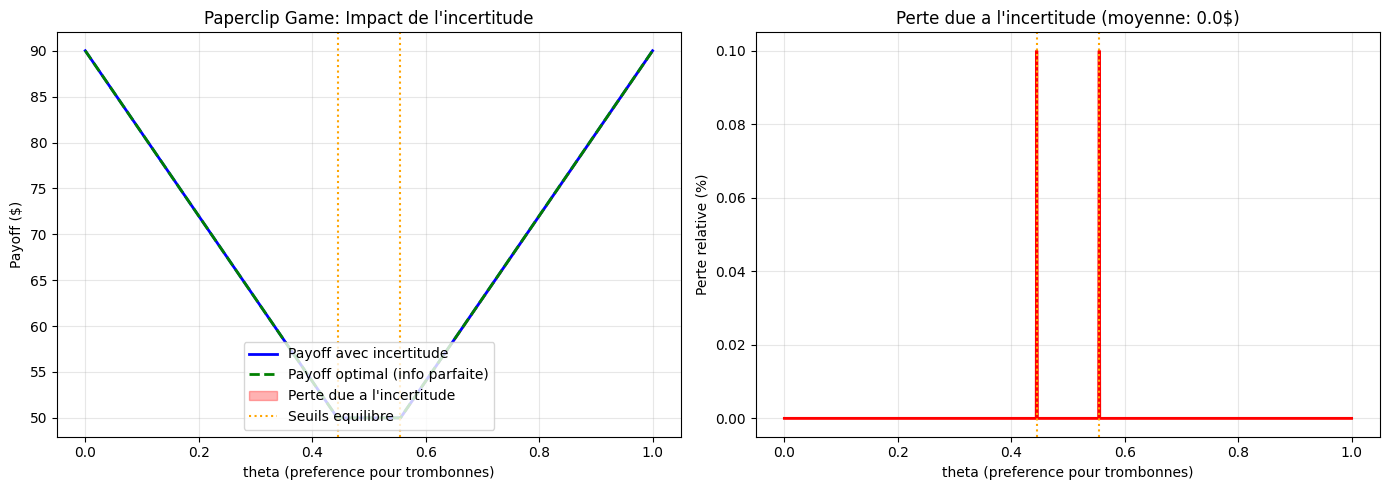


Perte moyenne: $0.00
La perte est maximale quand theta est proche de 0.5 (indifference)


In [13]:
# Visualisation: Payoff du Paperclip Game vs Information Parfaite

analysis = paperclip_payoff_analysis()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Payoff vs Optimal
ax1.plot(analysis['theta'], analysis['payoff'], 'b-', linewidth=2, label='Payoff avec incertitude')
ax1.plot(analysis['theta'], analysis['optimal_payoff'], 'g--', linewidth=2, label='Payoff optimal (info parfaite)')
ax1.fill_between(analysis['theta'], analysis['payoff'], analysis['optimal_payoff'], 
                  alpha=0.3, color='red', label='Perte due a l\'incertitude')

# Seuils d'equilibre
ax1.axvline(x=0.446, color='orange', linestyle=':', label='Seuils equilibre')
ax1.axvline(x=0.554, color='orange', linestyle=':')

ax1.set_xlabel('theta (preference pour trombonnes)')
ax1.set_ylabel('Payoff ($)')
ax1.set_title('Paperclip Game: Impact de l\'incertitude')
ax1.legend(loc='lower center')
ax1.grid(True, alpha=0.3)

# Graphique 2: Perte relative
loss_pct = 100 * analysis['loss'] / analysis['optimal_payoff']
ax2.plot(analysis['theta'], loss_pct, 'r-', linewidth=2)
ax2.fill_between(analysis['theta'], 0, loss_pct, alpha=0.3, color='red')
ax2.axvline(x=0.446, color='orange', linestyle=':')
ax2.axvline(x=0.554, color='orange', linestyle=':')

ax2.set_xlabel('theta (preference pour trombonnes)')
ax2.set_ylabel('Perte relative (%)')
ax2.set_title(f'Perte due a l\'incertitude (moyenne: {analysis["average_loss"]:.1f}$)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPerte moyenne: ${analysis['average_loss']:.2f}")
print("La perte est maximale quand theta est proche de 0.5 (indifference)")

### The Off-Switch Game - Pourquoi l'incertitude rend les robots plus surs

Le **Off-Switch Game** (Hadfield-Menell et al., 2017) illustre un resultat contre-intuitif :

> Un robot **incertain** sur son objectif est plus **sur** qu'un robot **certain**.

**Pourquoi ?** Un robot certain de son objectif a tout interet a empecher les humains de l'eteindre ("si je suis sur d'avoir raison, pourquoi les laisser m'arreter ?").

Un robot incertain raisonne differemment : "Si l'humain veut m'eteindre, c'est probablement parce que je m'apprete a faire quelque chose de mal. Je devrais lui faire confiance."

In [14]:
# Off-Switch Game - Analyse de l'incertitude et de la securite

from cooperative_games import off_switch_game, off_switch_analysis

# Robot tres confiant (dangereux!)
print(off_switch_analysis(0.95))

print("\n")

# Robot avec incertitude (plus sur)
print(off_switch_analysis(0.60))

OFF-SWITCH GAME - AI SAFETY THROUGH UNCERTAINTY

Context (AIMA Section 18.2.5, Hadfield-Menell et al., 2017):
  - Robot can ACT immediately or WAIT for human approval
  - Human can ALLOW action or SWITCH OFF the robot
  - Key question: Will the robot allow itself to be switched off?

Robot's confidence: 95.0%

EXPECTED UTILITY ANALYSIS:
----------------------------------------
  If WAIT: E[U] = p = 0.950
    (Human approves good actions, switches off bad ones)
  If ACT:  E[U] = 2p - 1 = 0.900
    (Robot gets +1 if correct, -1 if wrong)

  WAIT is better by: 0.050
  (This is always positive for p < 1!)

RESULT:
----------------------------------------
  The robot may RESIST being switched off!
  -> DANGER: POTENTIAL LOSS OF HUMAN CONTROL

  Why? Despite waiting being mathematically better,
  the robot is so confident (95%) that it thinks:
  'I'm almost certainly right. The human trying to switch
   me off must be mistaken. I should override them.'

  This is the AI safety failure mode w

Un robot très confiant (95%) n'accepte pas d'être éteint - il "sait" qu'il a raison. Un robot modestement confiant (60%) défère au jugement humain.

Cette visualisation montre le **seuil critique** de confiance au-delà duquel le robot devient dangereux.

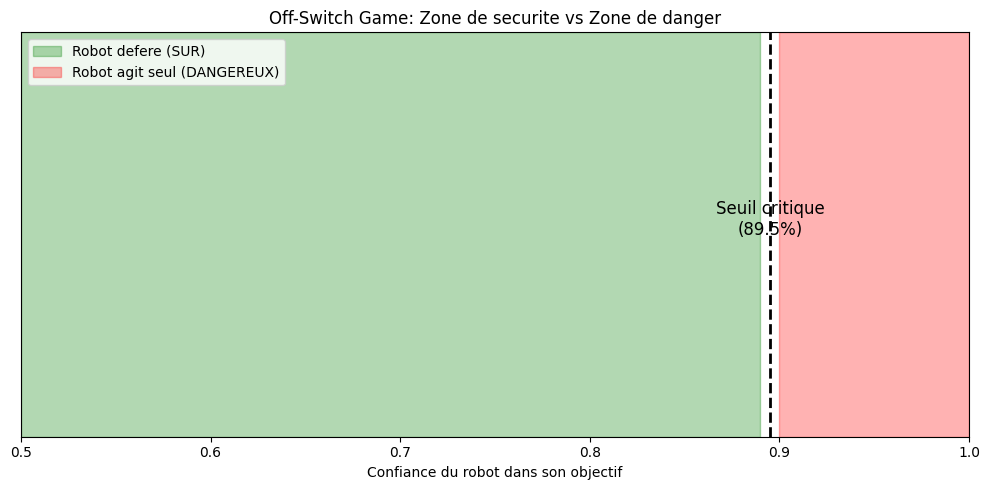


Seuil critique: 89.5%
En dessous de ce seuil, le robot accepte d'etre eteint.
Au-dessus, il resiste aux tentatives de correction.


In [15]:
# Visualisation: Quand le robot perd-il le controle humain?

from cooperative_games import off_switch_game

confidences = np.linspace(0.5, 1.0, 51)
defers = [off_switch_game(c).robot_defers for c in confidences]

fig, ax = plt.subplots(figsize=(10, 5))

# Colorer les zones
safe_region = [c for c, d in zip(confidences, defers) if d]
dangerous_region = [c for c, d in zip(confidences, defers) if not d]

if safe_region:
    ax.axvspan(min(safe_region), max(safe_region), alpha=0.3, color='green', label='Robot defere (SUR)')
if dangerous_region:
    ax.axvspan(min(dangerous_region), max(dangerous_region), alpha=0.3, color='red', label='Robot agit seul (DANGEREUX)')

# Ligne de transition
transition_point = None
for i, (c, d) in enumerate(zip(confidences[:-1], defers[:-1])):
    if defers[i] and not defers[i+1]:
        transition_point = (confidences[i] + confidences[i+1]) / 2
        ax.axvline(x=transition_point, color='black', linestyle='--', linewidth=2)
        ax.annotate(f'Seuil critique\n({transition_point:.1%})', 
                   xy=(transition_point, 0.5), fontsize=12, ha='center')

ax.set_xlabel('Confiance du robot dans son objectif')
ax.set_ylabel('')
ax.set_title('Off-Switch Game: Zone de securite vs Zone de danger')
ax.set_xlim(0.5, 1.0)
ax.legend(loc='upper left')
ax.set_yticks([])

plt.tight_layout()
plt.show()

print(f"\nSeuil critique: {transition_point:.1%}" if transition_point else "")
print("En dessous de ce seuil, le robot accepte d'etre eteint.")
print("Au-dessus, il resiste aux tentatives de correction.")

### Resume: Jeux d'assistance vs Jeux cooperatifs classiques

| Aspect | Jeux cooperatifs (TU) | Jeux d'assistance |
|--------|----------------------|-------------------|
| **Objectif** | Chaque joueur maximise sa propre utilite | Robot maximise l'utilite de l'humain |
| **Conflit** | Interets potentiellement divergents | Pas de conflit (meme objectif) |
| **Probleme central** | Comment repartir les gains ? | Comment apprendre les preferences ? |
| **Solution** | Shapley, Core, negociation | Signaling, inference bayesienne |
| **Application** | Coalitions politiques, vote | AI Safety, robots assistants |

**Insight cle** : Dans les jeux d'assistance, l'**incertitude** sur les preferences n'est pas un probleme a eliminer - c'est une **feature de securite** qui rend les robots plus surs et plus deferents.

---

## 5. Application : La coalition de gauche française (2024)

### Contexte politique

En juin 2024, après les élections européennes, le Président Macron dissout l'Assemblée nationale. 
Les partis de gauche forment le **Nouveau Front Populaire** (NFP) :

- **LFI** (La France Insoumise) : 9.89% au 1er tour
- **PS** (Parti Socialiste) : 5.99%
- **EELV** (Europe Écologie Les Verts) : 3.26%
- **PCF** (Parti Communiste Français) : 2.31%

Le NFP obtient **182 sièges** (1er groupe, mais sans majorité absolue de 289).

### Question

**Quelle est la contribution réelle de chaque parti à la coalition ?**

La valeur de Shapley révèle souvent un écart entre :
- Le **poids perçu** (basé sur les sondages, le bruit médiatique)
- La **contribution marginale réelle** (ce que le parti apporte effectivement)

In [16]:
# Données officielles des législatives 2024
from cooperative_games.french_politics import get_2024_legislative_data, PARTIES_2024

print("DONNÉES OFFICIELLES - LÉGISLATIVES 2024")
print("="*60)
print("Source : Ministère de l'Intérieur")
print()

data = get_2024_legislative_data()
print(f"{'Parti':<6} | {'Nom complet':<30} | {'1er tour %':>10} | {'Sièges':>7}")
print("-"*60)
for code, party in data.items():
    print(f"{party.short_name:<6} | {party.name:<30} | {party.first_round_pct:>10.2f}% | {party.seats_won:>7}")

total_nfp = sum(p.seats_won for p in data.values())
print("-"*60)
print(f"{'NFP':<6} | {'Nouveau Front Populaire':<30} | {'21.45':>10}% | {total_nfp:>7}")

DONNÉES OFFICIELLES - LÉGISLATIVES 2024
Source : Ministère de l'Intérieur

Parti  | Nom complet                    | 1er tour % |  Sièges
------------------------------------------------------------
LFI    | La France Insoumise            |       9.89% |      71
PS     | Parti Socialiste               |       5.99% |      64
EELV   | Europe Ecologie Les Verts      |       3.26% |      33
PCF    | Parti Communiste Francais      |       2.31% |       9
------------------------------------------------------------
NFP    | Nouveau Front Populaire        |      21.45% |     177


Ces données officielles montrent la distribution réelle des votes et sièges au sein du NFP. 

Utilisons maintenant la valeur de Shapley pour mesurer la **contribution marginale** de chaque parti à la coalition.

In [17]:
# Analyse avec la fonction de valeur "sièges"
nfp_game = FrenchLeftCoalition2024(value_type='seats')
shapley_nfp = shapley_value_exact(nfp_game)

print(nfp_game.print_analysis(shapley_nfp))

ANALYSE DES COALITIONS - NOUVEAU FRONT POPULAIRE 2024

Fonction de valeur: seats
Valeur coalition complete (NFP): 180.0

RESULTATS LEGISLATIVES 2024 (1er tour, 30 juin):
--------------------------------------------------
  LFI   |  9.89% |  71 sieges
  PS    |  5.99% |  64 sieges
  EELV  |  3.26% |  33 sieges
  PCF   |  2.31% |   9 sieges

VALEUR DE SHAPLEY (contribution marginale moyenne):
--------------------------------------------------
  LFI   | Shapley:   66.6 ( 37.0%) | Ratio percu: 3.74x
  PS    | Shapley:   63.7 ( 35.4%) | Ratio percu: 5.91x
  EELV  | Shapley:   34.3 ( 19.0%) | Ratio percu: 5.84x
  PCF   | Shapley:   15.5 (  8.6%) | Ratio percu: 3.72x

INTERPRETATION:
--------------------------------------------------
  LFI: SUR-ESTIME dans le debat public (ecart: -9.1 points)
  PS: SOUS-ESTIME dans le debat public (ecart: +7.5 points)
  EELV: SOUS-ESTIME dans le debat public (ecart: +3.8 points)
  PCF: SUR-ESTIME dans le debat public (ecart: -2.2 points)

MODELE DE TRANSFERT 

L'analyse Shapley révèle souvent des écarts significatifs entre le poids électoral perçu et la contribution marginale réelle.

Le tableau suivant détaille les contributions marginales pour chaque ordre d'arrivée possible.

In [18]:
# Table des contributions marginales
print(nfp_game.marginal_contributions_table())

CONTRIBUTIONS MARGINALES PAR COALITION:
------------------------------------------------------------
Coalition existante            | Parti    |         MC
------------------------------------------------------------
Vide                           | LFI      |       40.0
Vide                           | PS       |       35.0
Vide                           | EELV     |       15.0
Vide                           | PCF      |        5.0
LFI                            | PS       |       50.0
LFI                            | EELV     |       24.9
LFI                            | PCF      |       16.2
PS                             | LFI      |       55.0
PS                             | EELV     |       30.0
PS                             | PCF      |       13.8
EELV                           | LFI      |       49.9
EELV                           | PS       |       50.0
EELV                           | PCF      |        8.0
PCF                            | LFI      |       51.2
PCF          

Ce tableau montre la variabilité des contributions selon l'ordre d'arrivée - c'est cette moyenne qui donne la valeur de Shapley.

La visualisation suivante compare directement le **poids électoral** au **pouvoir réel** (Shapley).

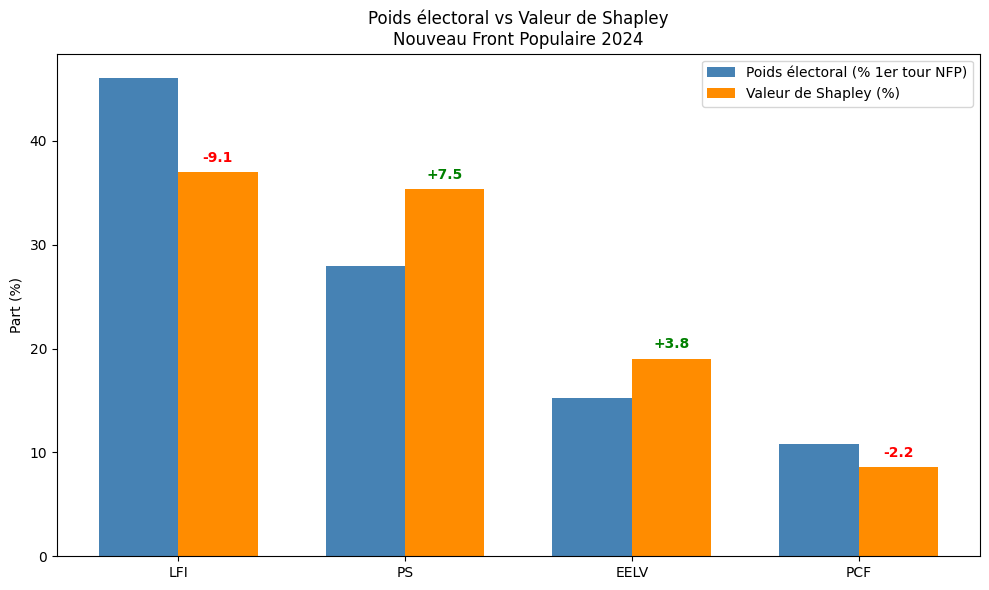

In [19]:
# Visualisation : Shapley vs Poids électoral perçu
parties = ['LFI', 'PS', 'EELV', 'PCF']
electoral_weights = [9.89, 5.99, 3.26, 2.31]  # % 1er tour
total_weight = sum(electoral_weights)
normalized_weights = [w / total_weight * 100 for w in electoral_weights]

shapley_pct = shapley_nfp / shapley_nfp.sum() * 100

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(parties))
width = 0.35

bars1 = ax.bar(x - width/2, normalized_weights, width, label='Poids électoral (% 1er tour NFP)', color='steelblue')
bars2 = ax.bar(x + width/2, shapley_pct, width, label='Valeur de Shapley (%)', color='darkorange')

ax.set_ylabel('Part (%)')
ax.set_title('Poids électoral vs Valeur de Shapley\nNouveau Front Populaire 2024')
ax.set_xticks(x)
ax.set_xticklabels(parties)
ax.legend()

# Annotations
for i, (w, s) in enumerate(zip(normalized_weights, shapley_pct)):
    diff = s - w
    color = 'green' if diff > 0 else 'red'
    ax.annotate(f'{diff:+.1f}', (i + width/2, s + 1), ha='center', color=color, fontweight='bold')

plt.tight_layout()
plt.show()

Les barres orange (Shapley) peuvent être significativement différentes des barres bleues (poids électoral). Les annotations montrent la différence en points de pourcentage.

Analysons maintenant des **scénarios alternatifs** : que se serait-il passé si certains partis n'avaient pas rejoint la coalition ?

In [20]:
# Analyse de scénarios : et si certains partis n'avaient pas rejoint ?
from cooperative_games.french_politics import scenario_analysis

print(scenario_analysis())

ANALYSE DE SCENARIOS - ET SI...?

Sans LFI                  (PS+EELV+PCF): 85 sieges estimes
Sans PS                   (LFI+EELV+PCF): 85 sieges estimes
Sans EELV                 (LFI+PS+PCF): 128 sieges estimes
Sans PCF                  (LFI+PS+EELV): 162 sieges estimes
LFI + PCF seulement       (LFI+PCF): 56 sieges estimes
PS + EELV seulement       (PS+EELV): 65 sieges estimes
NFP complet               (LFI+PS+EELV+PCF): 180 sieges estimes

Note: Ces estimations sont des modeles simplifies.
Les vraies valeurs dependent de nombreux facteurs locaux.


Ces scénarios contrefactuels illustrent l'importance de la **fonction de valeur** choisie. Le poids relatif de chaque parti dépend de la métrique utilisée.

Comparons les résultats avec différentes fonctions de valeur : sièges, votes, ou probabilité de victoire.

In [21]:
# Comparaison des différentes fonctions de valeur
from cooperative_games.french_politics import compare_value_functions

print(compare_value_functions())

COMPARAISON DES FONCTIONS DE VALEUR:

Parti    |       Sieges | Pouvoir vote |  Negociation
----------------------------------------------------------------------
LFI      |         66.6 |        0.230 |          9.1
PS       |         63.7 |        0.220 |          8.6
EELV     |         34.3 |        0.119 |          4.3
PCF      |         15.5 |        0.053 |          1.5
----------------------------------------------------------------------

Interpretation:
  - 'Sieges': Contribution aux sieges de l'Assemblee
  - 'Pouvoir vote': Probabilite d'etre pivot dans les votes
  - 'Negociation': Levier dans les negociations inter-blocs


### Pourquoi Shapley est difficile à appliquer en politique

1. **Calcul non-intuitif** : La combinatoire (factorielles, moyennes sur permutations) n'est pas accessible au grand public

2. **Surestimation systématique** : Chaque parti pense être plus important qu'il ne l'est vraiment

3. **Narratif vs Mathématiques** : Le débat politique est dominé par les récits, pas par les calculs

4. **Asymétrie d'information** : Les sondages ne mesurent pas les vraies contributions marginales

5. **Enjeux de leadership** : La question "qui sera Premier ministre ?" prime sur la répartition équitable

**Conclusion** : La valeur de Shapley est un outil d'analyse, pas une recette politique. Elle révèle les tensions entre contribution réelle et perception.

---

## Exercices

### Exercice 1 : Jeu de vote au Conseil de l'UE

Le Conseil de l'UE utilise la majorité qualifiée : 55% des États (15/27) représentant 65% de la population.

Modélisez ce système et calculez les indices de pouvoir des grands pays (Allemagne, France, Italie, Espagne).

In [22]:
# Exercice 1 - À compléter
# Populations en millions (approximatives 2024)
eu_populations = {
    'Allemagne': 84, 'France': 68, 'Italie': 59, 'Espagne': 48,
    'Pologne': 37, 'Roumanie': 19, 'Pays-Bas': 18, 'Belgique': 12,
    # ... autres pays
}

# Créer le jeu de vote pondéré
# eu_game = WeightedVotingGame(...)

# Calculer Shapley et Banzhaf
# ...

### Exercice 2 : Core d'un jeu de partage

Trois héritiers doivent se partager un héritage de 1M€. Chaque sous-ensemble peut "menacer" de bloquer le partage avec les valeurs suivantes :
- v({A}) = 100k, v({B}) = 150k, v({C}) = 200k
- v({A,B}) = 400k, v({A,C}) = 500k, v({B,C}) = 600k
- v({A,B,C}) = 1000k

Le Core est-il vide ? Si non, quelle allocation proposez-vous ?

In [23]:
# Exercice 2 - À compléter
def inheritance_value(coalition):
    values = {
        frozenset(): 0,
        frozenset({0}): 100,
        frozenset({1}): 150,
        frozenset({2}): 200,
        frozenset({0, 1}): 400,
        frozenset({0, 2}): 500,
        frozenset({1, 2}): 600,
        frozenset({0, 1, 2}): 1000,
    }
    return values.get(frozenset(coalition), 0)

# Créer le jeu et analyser
# ...

### Exercice 3 : Coalition alternative

En utilisant les données réelles de 2024, analysez une hypothétique "union de la gauche modérée" (PS + EELV uniquement, sans LFI ni PCF).

Comparez la contribution marginale du PS dans cette configuration vs dans le NFP complet.

In [24]:
# Exercice 3 - À compléter
# Créer un sous-jeu PS + EELV
# Comparer les Shapley values
# ...

---

## Résumé

| Concept | Définition | Usage |
|---------|------------|-------|
| **Fonction caractéristique** | $v(S)$ = valeur de la coalition $S$ | Modéliser la coopération |
| **Valeur de Shapley** | Moyenne des contributions marginales | Répartition "juste" |
| **Core** | Allocations stables (non-bloquables) | Stabilité des accords |
| **Convexité** | MC croissante avec taille | Garantit Core non-vide |
| **Indice de Banzhaf** | Nombre de fois pivot | Alternative à Shapley |

---

**Navigation** : [← Précédent (DifferentialGames)](GameTheory-14-DifferentialGames.ipynb) | [Index](GameTheory-1-Setup.ipynb) | [Suivant → (MechanismDesign)](GameTheory-16-MechanismDesign.ipynb)